In [1]:
# Import the nessecary libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# WORKING - Given a filename, read the file as a dataframe
data = pd.read_csv('cancer.csv', header = None)

In [3]:
# WORKING
# Euclidian distance formula. Takes two iterables of coordinates arguments and returns the distance between them.
def calculate_distance(coords_1, coords_2):
    # Basic precondition check
    assert (len(coords_1) == len(coords_2)), "Coordinate lists have different lengths!"
    # Iterate through each coordinate and keep a running sum of their squares
    sum_squares = 0
    for i in range(0, len(coords_1)):
        difference = coords_1[i] - coords_2[i]
        sum_squares += (difference * difference)
    # Return the square root of our sum
    distance =  math.sqrt(sum_squares)
    return(distance)

In [4]:
# A class to represent our individual data points (or rows in our datafrane)
class DataPoint():
    def __init__(self, centroids, dataFrame, row):
        
        # so we can reference the original dataframe as needed
        self.data = dataFrame.iloc[row]    
        
        # WORKING - set up each data point
        self.listData = []
        for i in self.data:
            self.listData.append(self.data.iat[0, i])
        self.listData = self.listData[1:]
        
        # WORKING - Assign a group / centroid at random
        self.nearestCentroid = np.random.randint(len(centroids))

    # WORKING - This is ugly, but since it's only for testing I don't really care.
    def __repr__(self):
        repStr = ''
        for i in self.listData:
            repStr += str(i) + ', '
        return repStr.strip()[0: -1] + '\n'

    # Iterate through all the centroids and find the nearest one.
    def getNearestCentroid(self, centroids):
        nearest = 0
        nearestDistance = calculate_distance(self.listData, centroids[0])
        for i in range(0, len(centroids)):
            newDistance = calculate_distance(self.listData, centroids[i])
            if newDistance < nearestDistance:
                nearestDistance = newDistance
                nearest = i
        return nearest

In [5]:
# WORKING - Create K random centroids based on our dataset
def random_centroids(k, data_frame):
    centroids = []
    for i in range(0, k):
        coords = []
        for j in range(1, len(data_frame.columns)):
            coords.append(np.random.randint(-5, 6))
        centroids.append(coords)
    return centroids

In [6]:
# WORKING - Create a list of datapoints, one for each row of our dataframe
def create_points(centroids, dataFrame):
    pointList = []
    for i in range(0, len(dataFrame.index)):
        pointList.append(DataPoint(centroids, dataFrame,[i]))
    return pointList

In [7]:
def calculate_centroids(pointList, centroids):
    points = []
    # For each centroid
    for i in range(0, len(centroids)):
        # Make a list of all points that have it assigned as their "nearestCentroid"
        points = []
        for point in pointList:
            if point.nearestCentroid == i:
                points.append(point)
        # Now we calculate our new centroid by taking the average of all values in our list
        if len(points) > 0:
            # Originally this was a one-liner, but I had to split it up for debugging purposes.
            # Make a list of all the points
            array_base = []
            for point in points:
                array_base += point.listData
            # Turn that into a numpy array and reshape it so each point's values are stacked on top of one another
            array = np.array(array_base).reshape(len(points), (len(data.columns) - 1))
            # Sum our columns
            array_sum = np.sum(array, 0)
            # Divide by the number of rows to get our new centroid
            array_avg = array_sum / len(points)
            # Convert it back into a list
            array_list = array_avg.tolist()
            # Assign this as our new centroid
            centroids[i] = array_list

In [8]:
# WORKING - Calculates our new centroids based on their grouping
def assign_centroids(pointList, centroids):
    for i in pointList:
        i.nearestCentroid = i.getNearestCentroid(centroids)

In [9]:
# WORKING - Our complete function
def k_means(k, raw_data, iter_max):
    centroids = random_centroids(k, data)
    pointList = create_points(centroids, data)
    
    # Initialize a list for use in checking cluster assignments
    clusters = []
    # Iterate repeatedly, recalculating centroids and reassigning groups until assignments stay the same
    for i in range(0, iter_max):
        calculate_centroids(pointList, centroids)
        assign_centroids(pointList, centroids)
        
        # Check if our cluster assignments have changed
        new_clusters = [point.nearestCentroid for point in pointList]
        # If there is no change then we are finished and can return
        if new_clusters == clusters:
            break
    
                         # start our list of values that will be used for plotting.
    dfList = []
    # Add our points to our list of lists in order of cluster assignments
    for i in range(0, k):
        for point in pointList:
            if point.nearestCentroid == i:
                dfList.append(point.listData)
    # Make dfList into a dataframe so we can plot it
    plotDf = pd.DataFrame(dfList)
    
    # Create the plot
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.pcolor(dfList, cmap = 'RdBu')
    

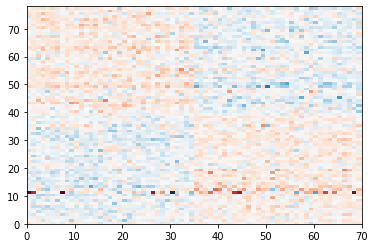

In [10]:
# Make the magic happen!
k_means(2, data, 100)


## Discussion
    
    Overall this worked out quite well. I chose to define the class DataPoint so that I would not have to continusously reference the initial dataframe. Pandas is incredibly useful, but a large part of its funcitonality is excessive here. Instead I chose to convert each row's data into a DataPoint object and store the raw data as a list. Realistically this should be stored as a tuple instead but I'm almost done here and don't want to rewrite a bunch of code/references
    
    I chose to separate each task into its own function/method so that the code could be both modular (for easy testing purposes) and readable. This made debugging much more straightforward.
    
    Centroid / cluster data was stored simply as lists. Each centroid simply had a list of values that were updated each iteration, and each data point stored a value that was the index of the list of centroids for the centroid it was nearest to. This made things very quick and easy.
    
    Finally the value of 2 was chosen for k in our final run of the algorithm. In an ideal world I would have the time to code up an automated version of the elbow method for determining optimal k, but I have a lot to do this afternoon so I'm going to end it here. Instead I experimented with different values manually. K = 2 had the most obvious delination between groups in the final heatmap, though 3 groups was almost as marked (with a lot of neutral groups falling together). Ultimately 2 groups also fits a binary model of YES/NO cancer risk based on gene expression (though obviously this is a sliding scale in reality, all data analysis is an abstraction).
